## Detection of Tomato Leaf Disease by Transfer learning InceptionV3

#### Importing libraries and essentials for the model

In [3]:
from tensorflow import keras 
from tensorflow.keras.layers import Dense , Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

##### Data Augmentation

Increasing the data by horizontal flip, shear range and rotation range to get the image classification better accuracy.
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data.

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,rotation_range=.2,shear_range=.2)
test_datagen=ImageDataGenerator(rescale=1./255)

##### About Dataset

   1. The dataset consists of training data, validation data, and testing data.
   2. The training data consists of 18345  images with 10 classes and 3,875 test images with 10.
   3. The classes are Tomato___Bacterial_spot, Tomato___Early_blight, Tomato___healthy, Tomato___Late_blight, Tomato___Leaf_Mold, Tomato___Septoria_leaf_spot, Tomato___Spider_mites Two-spotted_spider_mite, Tomato___Target_Spot, Tomato___Tomato_mosaic_virus, Tomato___Tomato_Yellow_Leaf_Curl_Virus.

In [29]:
training_set=train_datagen.flow_from_directory("/content/drive/MyDrive/tomato_dataset/train",
                                               target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=True)
test_set=test_datagen.flow_from_directory("/content/drive/MyDrive/tomato_dataset/test",
                                          target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=True)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


### InceptionV3

Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision.

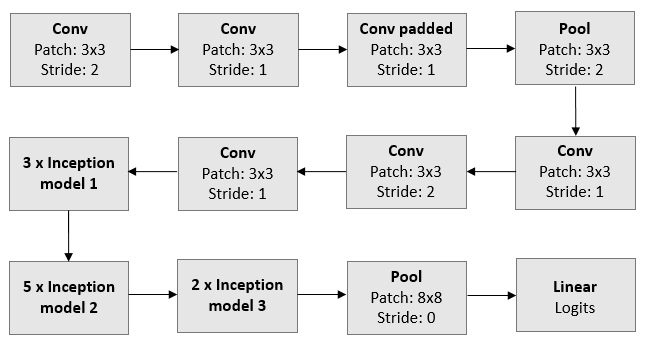

In [30]:
inception=InceptionV3(input_shape=[224,224,3],weights="imagenet",include_top=False)

**We will not train the layers because the layers of InceptionV3 layers are already trained with imagenet dataset.** 

In [31]:
for layer in inception.layers:
  layer.trainable=False

In [33]:
folder=glob("/content/drive/MyDrive/tomato_dataset/train/*")

**Adding a flatten layer along with a Dense layer whose neuron will be equal to the number of classes with and activation funtion softmax**

**Then we will concat the model and name inception_model**

In [34]:
x=Flatten()(inception.output)
predict_inception=Dense(units=len(folder),activation="softmax")(x)
inception_model=Model(inputs=inception.input,outputs=predict_inception)

**We have taken the optimizer Adam and the loss will be categorical crossentropy and our aim will be to find the accuracy**

In [38]:
inception_model.compile(optimizer="adam",
                        loss="categorical_crossentropy",metrics=["accuracy"])

#### Final Architecture

In [39]:
inception_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

**Train the model with an epoch of 20 and the validation data will be the test data**

In [40]:
transfer_inception=inception_model.fit_generator(training_set,validation_data=test_set,
                                                 validation_steps=len(test_set),steps_per_epoch=len(training_set),epochs=20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
574/574 [==============================] - 6237s 11s/step - loss: 2.5780 - accuracy: 0.7024 - val_loss: 2.6188 - val_accuracy: 0.7592
Epoch 2/20
574/574 [==============================] - 214s 373ms/step - loss: 1.6697 - accuracy: 0.8285 - val_loss: 3.0188 - val_accuracy: 0.7564
Epoch 3/20
574/574 [==============================] - 213s 371ms/step - loss: 1.3023 - accuracy: 0.8658 - val_loss: 2.2366 - val_accuracy: 0.8284
Epoch 4/20
574/574 [==============================] - 213s 371ms/step - loss: 1.2334 - accuracy: 0.8821 - val_loss: 1.9679 - val_accuracy: 0.8377
Epoch 5/20
574/574 [==============================] - 213s 371ms/step - loss: 1.0398 - accuracy: 0.9067 - val_loss: 1.7724 - val_accuracy: 0.8628
Epoch 6/20
574/574 [==============================] - 213s 371ms/step - loss: 1.0787 - accuracy: 0.9093 - val_loss: 1.8768 - val_accuracy: 0.8737
Epoch 7/20
574/574 [==============================] - 213s 372ms/step - loss: 0.9351 - accuracy: 0.9203 - val_loss: 2.4459 - 

After training the model I have noticed that the model is **Overfiiting.**

**Overfitting means for training dataset the model perform good but for test dataset the model will not perform well.**  

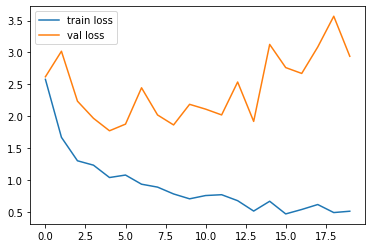

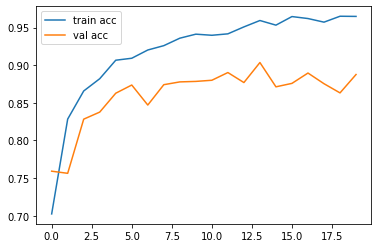

<Figure size 432x288 with 0 Axes>

In [41]:
# plot the loss
plt.plot(transfer_inception.history['loss'], label='train loss')
plt.plot(transfer_inception.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(transfer_inception.history['accuracy'], label='train acc')
plt.plot(transfer_inception.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#### Prediction

In [42]:
y_pred_incep=inception_model.predict(test_set)

**The predicted output is a probability due to the activation funtion Softmax, it returns probability of the classes
We will now change the probability to discrete values**

In [43]:
import numpy as np
y_pred_incep=np.argmax(y_pred_incep,axis=1)

**Saving the model**

In [44]:
inception_model.save("Tomato_inceptionv3.h5")
from tensorflow.keras.models import load_model
modelinception=load_model("Tomato_inceptionv3.h5")

**Testing the Model with validation dataset** 

Saving eee6e32f-ba05-44ff-a643-68d12ed65717___Com.G_TgS_FL 8282.JPG to eee6e32f-ba05-44ff-a643-68d12ed65717___Com.G_TgS_FL 8282.JPG
Tomato___Tomato_Yellow_Leaf_Curl_Virus


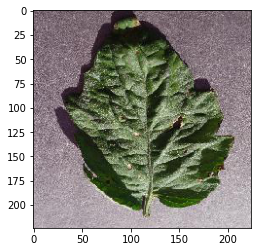

In [52]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis =0)

  preds = modelinception.predict(x)
  preds=np.argmax(preds, axis=1)
  if preds==0:
        preds="Tomato___Bacterial_spot"
  elif preds==1:
        preds="Tomato___Early_blight"
  elif preds==2:
        preds="Tomato___healthy"
  elif preds==3:
        preds="Tomato___Late_blight"
  elif preds==4:
        preds="Tomato___Leaf_Mold"
  elif preds==5:
        preds="Tomato___Septoria_leaf_spot"
  elif preds==6:
        preds="Tomato___Spider_mites Two-spotted_spider_mite"
  elif preds==7:
        preds="Tomato___Target_Spot"
  elif preds==8:
        preds="Tomato___Tomato_mosaic_virus"
  else:
        preds="Tomato___Tomato_Yellow_Leaf_Curl_Virus"
  print(preds)
  plt.imshow(img)